In [33]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import minimize, brentq, curve_fit
from scipy.integrate import quad

from prettytable import PrettyTable

In [2]:
data_size = 10**4
sim_size = 10**5
n_iterations = 5
n_bootstraps = 500
epsilon = 1e-8
rcond = 1e-3
rng = np.random.default_rng(seed = 5048)

mu_true, var_true = 0.2, 0.81
mu_gen, var_gen = 0.0, 1.0

smearing = 1e-5

In [3]:
truth = rng.normal(mu_true, np.sqrt(var_true), (n_bootstraps, data_size))
data = rng.normal(truth, smearing)
gen = rng.normal(mu_gen, np.sqrt(var_gen), (n_bootstraps, sim_size))
sim = rng.normal(gen, smearing)

In [4]:
bins = [truth.min()]
i = 0
while bins[-1] < truth.max() and i < len(bins):
    for binhigh in np.linspace(bins[i] + epsilon, truth.max(), 20):
        in_bin = (truth[0] > bins[i]) & (truth[0] < binhigh)
        in_reco_bin = (data[0] > bins[i]) & (data[0] < binhigh)
        if np.sum(in_bin) > 0:
            purity = np.sum(in_bin & in_reco_bin) / np.sum(in_bin)
            if purity > (0.5):
                i += 1
                bins.append(binhigh)
                break
    else:
        break
bins = np.array(bins)
bin_widths = np.diff(bins)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
n_bins = len(bins) - 1

In [5]:
normalization = False
normalize = lambda x: x / np.sum(x, axis=0) if normalization else x

def create_response_matrix(gen, sim, bins):
    H, _, _ = np.histogram2d(gen.ravel(), sim.ravel(), bins=[bins, bins])
    H = normalize(H)
    H[np.isnan(H)] = 0
    return H

def bayesian_unfolding_step(R, f, data_hist):
    reweight = data_hist / (R @ f + epsilon)
    reweight[np.isnan(reweight)] = 0
    reweight[(R @ f) == 0] = 0
    f_prime = f * (R @ reweight)
    return normalize(f_prime)

def iterative_bayesian_unfolding(data, gen, sim, bins, n_iterations):
    fs = np.empty((n_iterations, len(bins) - 1, ))
    R = create_response_matrix(gen, sim, bins)
    f, _ = np.histogram(gen, bins=bins)
    f = normalize(f)
    data_hist, _ = np.histogram(data, bins=bins)
    data_hist = normalize(data_hist)
    sim_hist, _ = np.histogram(sim, bins=bins)
    sim_hist = normalize(sim_hist)
    
    for i in range(n_iterations):
        f = bayesian_unfolding_step(R, f, data_hist)
        fs[i] = f
    return fs

def neg_log_likelihood(params, x, y, cov):
    A, mu, var = params
    cdf_values = norm.cdf(x, mu, np.sqrt(var))
    y_model = A/np.sqrt(2*np.pi*var) * np.diff(cdf_values)
    scaling_factor = 1e0  # Adjust this factor to balance the contributions
    return 0.5 * (y - y_model).T @ np.linalg.pinv(cov, rcond=rcond) @ (y - y_model) * scaling_factor

def find_confidence_interval(nll, param_index, param_value, nll_min, x, y, cov, bounds):
    def target_function(test_value):
        test_params = param_value.copy()
        test_params[param_index] = test_value
        return nll(test_params, x, y, cov) - (nll_min + 0.5)
    
    lower_bound = brentq(target_function, bounds[param_index][0], param_value[param_index])
    upper_bound = brentq(target_function, param_value[param_index], bounds[param_index][1])
    
    return lower_bound, upper_bound

In [6]:
unfolded_results = np.empty((n_bootstraps, n_iterations, n_bins))
for i in range(n_bootstraps):
    unfolded_results[i] = iterative_bayesian_unfolding(data[i], gen[i], sim[i], bins, n_iterations)
unfolded_results_last = unfolded_results[:, -1]

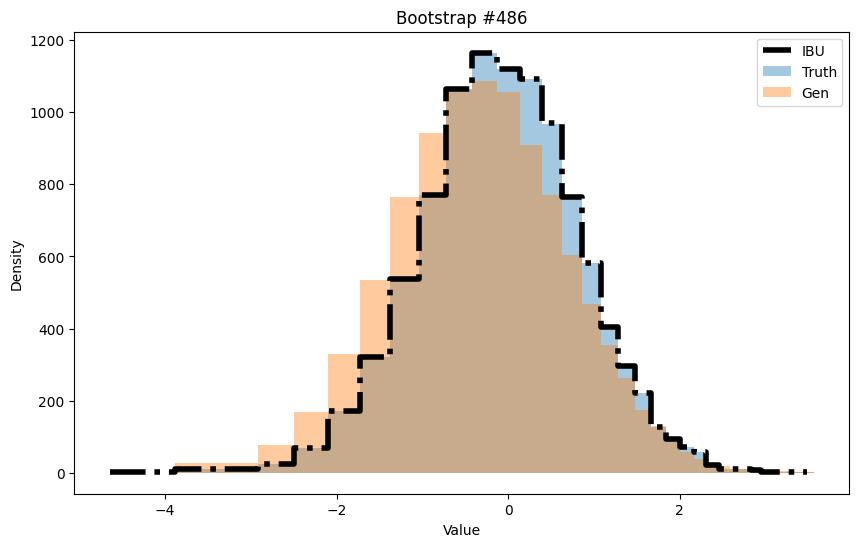

In [7]:
plt.figure(figsize=(10, 6))

k = rng.integers(0, n_bootstraps)

# for i, result in enumerate(unfolded_results[k]):
#     plt.step(bins[:-1], result, where='mid', label=f'{i+1}', alpha = 0.5)



truth_hist, _ = np.histogram(truth[k], bins=bins)
gen_hist, _ = np.histogram(gen[k], bins=bins)

plt.step(bins[:-1], unfolded_results[k, -1], where='mid', ls = "-.", lw = 4, color = 'black', label = 'IBU')
plt.fill_between(bin_centers, (truth_hist), step="pre", alpha=0.4, label = 'Truth')
plt.fill_between(bin_centers, (gen_hist)*data_size/sim_size, step="pre", alpha=0.4,  label = 'Gen')
# Labels and title
plt.legend()
plt.xlabel('Value')
plt.ylabel('Density')
plt.title(f'Bootstrap #{k}')
plt.show()

In [8]:
unfolded_means = np.sum(unfolded_results_last * bin_centers, axis=1)/np.sum(unfolded_results_last, axis=1)
unfolded_vars = np.sum(unfolded_results_last * (bin_centers - unfolded_means[:, None])**2, axis=1)/np.sum(
    unfolded_results_last, axis=1)

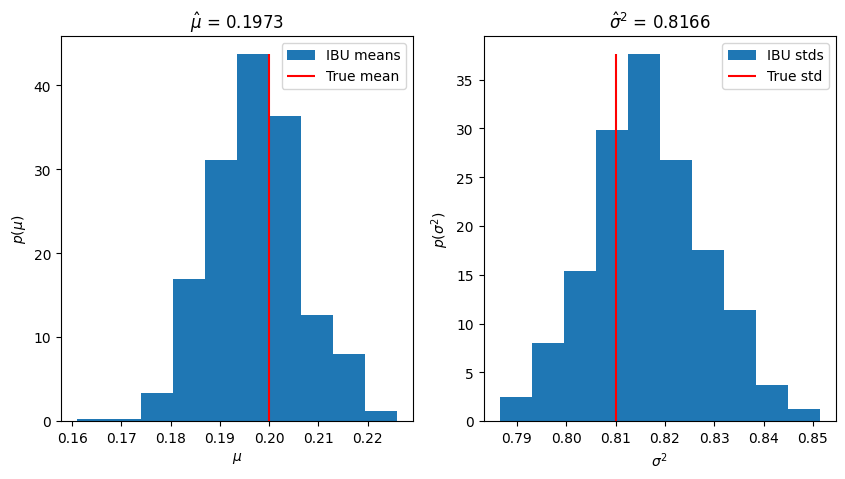

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
h, _, _ = ax[0].hist(unfolded_means, label = 'IBU means', density = True)
ax[0].vlines(mu_true, 0, h.max(), color = 'r', label = 'True mean')
ax[0].legend()
ax[0].set_xlabel(r"$\mu$")
ax[0].set_ylabel(r"$p(\mu)$")
ax[0].set_title(f"$\\hat\\mu$ = {unfolded_means.mean():.4f}")

h, _, _ = ax[1].hist(unfolded_vars, label = 'IBU stds', density = True)
ax[1].vlines(var_true, 0, h.max(), color = 'r', label = 'True std')
ax[1].legend()
ax[1].set_xlabel(r"$\sigma^2$")
ax[1].set_ylabel(r"$p(\sigma^2)$")
ax[1].set_title(f"$\\hat\\sigma^2$ = {unfolded_vars.mean():.4f}")

fig.show()

## Fitting with and without off diagonal cov

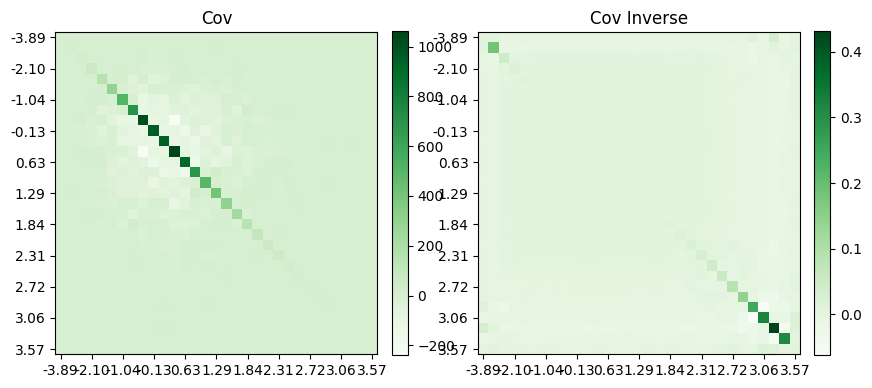

In [10]:
cov = np.cov(unfolded_results_last.T)
cov_diag = np.diag(np.diag(cov))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
cax = ax[0].matshow(cov, cmap='Greens')
fig.colorbar(cax, fraction=0.046, pad=0.04)

ax[0].set_xticks(np.arange(0, len(bin_centers), 3))
ax[0].set_yticks(np.arange(0, len(bin_centers), 3))
ax[0].set_xticklabels([f'{bc:.2f}' for bc in bin_centers[::3]])
ax[0].set_yticklabels([f'{bc:.2f}' for bc in bin_centers[::3]])

# Move x-axis tick labels to the bottom
ax[0].xaxis.set_ticks_position('bottom')
ax[0].xaxis.set_label_position('bottom')
ax[0].set_title('Cov')

covinv = np.linalg.pinv(cov, rcond=rcond)
cax = ax[1].matshow(covinv, cmap='Greens')
fig.colorbar(cax, fraction=0.046, pad=0.04)

ax[1].set_xticks(np.arange(0, len(bin_centers), 3))
ax[1].set_yticks(np.arange(0, len(bin_centers), 3))
ax[1].set_xticklabels([f'{bc:.2f}' for bc in bin_centers[::3]])
ax[1].set_yticklabels([f'{bc:.2f}' for bc in bin_centers[::3]])

# Move x-axis tick labels to the bottom
ax[1].xaxis.set_ticks_position('bottom')
ax[1].xaxis.set_label_position('bottom')
ax[1].set_title('Cov Inverse')

plt.show()

In [115]:
def gauss_pdf(x, A, mu, var):
    return A / np.sqrt(2 * np.pi * var) * np.exp(-0.5 * ((x - mu) ** 2) / var)

# Define the function to compute the integral of the PDF over the bin range
def gauss(x, A, mu, var):
    index = np.where(bin_centers == x)[0][0]
    left = bins[index]
    right = bins[index + 1]
    pdf = lambda x: gauss_pdf(x, A, mu, var)
    return quad(pdf, left, right)[0]

# Function to compute the negative log likelihood
def neg_log_likelihood(params, x, y, cov):
    A, mu, var = params
    y_model = np.array([gauss(center, A, mu, var) for center in x])
    return 0.5 * (y - y_model).T @ np.linalg.pinv(cov) @ (y - y_model)

In [116]:
fitted_params = np.empty((n_bootstraps, 3))
intervals = np.empty((n_bootstraps, 3, 3))
intervals_diag = np.empty((n_bootstraps, 3, 3))
fitted_params_diag = np.empty((n_bootstraps, 3))

for i in range(n_bootstraps):
    ibu_res = unfolded_results_last[i]
    fitted_params[i], _ = curve_fit(gaussian, bin_centers,
                    ibu_res, [10**4, 0, 1],
                    bounds=(0, [np.inf, np.inf, np.inf]),
                    sigma = cov,
                    absolute_sigma=True
    )

    fitted_params_diag[i], _ = curve_fit(gaussian, bin_centers,
                    ibu_res, [10**4, 0, 1],
                    bounds=(0, [np.inf, np.inf, np.inf]),
                    sigma = cov_diag,
                    absolute_sigma=True
    )

In [124]:
fitted_params = np.empty((n_bootstraps, 3))
intervals = np.empty((n_bootstraps, 3, 2))
intervals_diag = np.empty((n_bootstraps, 3, 2))
fitted_params_diag = np.empty((n_bootstraps, 3))

bounds = [(0, 10**5), (-1, 1), (epsilon, 4)]

for i in range(n_bootstraps):
    initial_guess = [10**4, 0, 1]
    result = minimize(neg_log_likelihood,
                      initial_guess,
                      args=(bin_centers, unfolded_results_last[i], cov),
                      bounds=bounds)

    nll_min = result.fun  # Minimum NLL value
    fitted_params[i] = result.x
    intervals[i, 0] = find_confidence_interval(neg_log_likelihood,
                                           0, result.x,
                                           nll_min,
                                           bin_centers,
                                           unfolded_results_last[i],
                                           cov,
                                           bounds)
    intervals[i, 1] = find_confidence_interval(neg_log_likelihood,
                                              1,
                                              result.x,
                                              nll_min,
                                              bin_centers,
                                              unfolded_results_last[i],
                                              cov,
                                              bounds)

    result_diag = minimize(neg_log_likelihood,
                           initial_guess,
                           args=(bin_centers, unfolded_results_last[i], cov_diag),
                           #method='L-BFGS-B',
                           bounds = bounds
                          )
    nll_min_diag = result_diag.fun  # Minimum NLL value
    fitted_params_diag[i] = result_diag.x
    intervals_diag[i, 0] = find_confidence_interval(neg_log_likelihood,
                                           0, result_diag.x,
                                           nll_min_diag,
                                           bin_centers,
                                           unfolded_results_last[i],
                                           cov_diag,
                                           bounds)
    intervals_diag[i, 1] = find_confidence_interval(neg_log_likelihood,
                                              1,
                                              result_diag.x,
                                              nll_min_diag,
                                              bins,
                                              unfolded_results_last[i],
                                              cov_diag,
                                              bounds)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [119]:
# fitted_params = np.empty((n_bootstraps, 3))
# intervals = np.empty((n_bootstraps, 3, 3))
# intervals_diag = np.empty((n_bootstraps, 3, 3))
# fitted_params_diag = np.empty((n_bootstraps, 3))

# bounds = [(100, 2000), (-1, 1), (epsilon, 4)]

# for i in range(n_bootstraps):
#     initial_guess = [max(truth_hist), 0.2, .81]
#     result = minimize(neg_log_likelihood,
#                       initial_guess,
#                       args=(bins, unfolded_results_last[i], cov),
#                       bounds=bounds)

#     nll_min = result.fun  # Minimum NLL value
#     fitted_params[i] = result.x
#     # intervals[i, 0] = find_confidence_interval(neg_log_likelihood,
#     #                                        0, result.x,
#     #                                        nll_min,
#     #                                        bins,
#     #                                        unfolded_results_last[i],
#     #                                        cov,
#     #                                        bounds)
#     # intervals[i, 1] = find_confidence_interval(neg_log_likelihood,
#     #                                           1,
#     #                                           result.x,
#     #                                           nll_min,
#     #                                           bins,
#     #                                           unfolded_results_last[i],
#     #                                           cov,
#     #                                           bounds)

#     result_diag = minimize(neg_log_likelihood,
#                            initial_guess,
#                            args=(bins, unfolded_results_last[i], cov_diag),
#                            #method='L-BFGS-B',
#                            bounds = bounds
#                           )
#     nll_min_diag = result_diag.fun  # Minimum NLL value
#     fitted_params_diag[i] = result_diag.x
#     # intervals_diag[i, 0] = find_confidence_interval(neg_log_likelihood,
#     #                                        0, result_diag.x,
#     #                                        nll_min_diag,
#     #                                        bins,
#     #                                        unfolded_results_last[i],
#     #                                        cov_diag,
#     #                                        bounds)
#     # intervals_diag[i, 1] = find_confidence_interval(neg_log_likelihood,
#     #                                           1,
#     #                                           result_diag.x,
#     #                                           nll_min_diag,
#     #                                           bins,
#     #                                           unfolded_results_last[i],
#     #                                           cov_diag,
#     #                                           bounds)

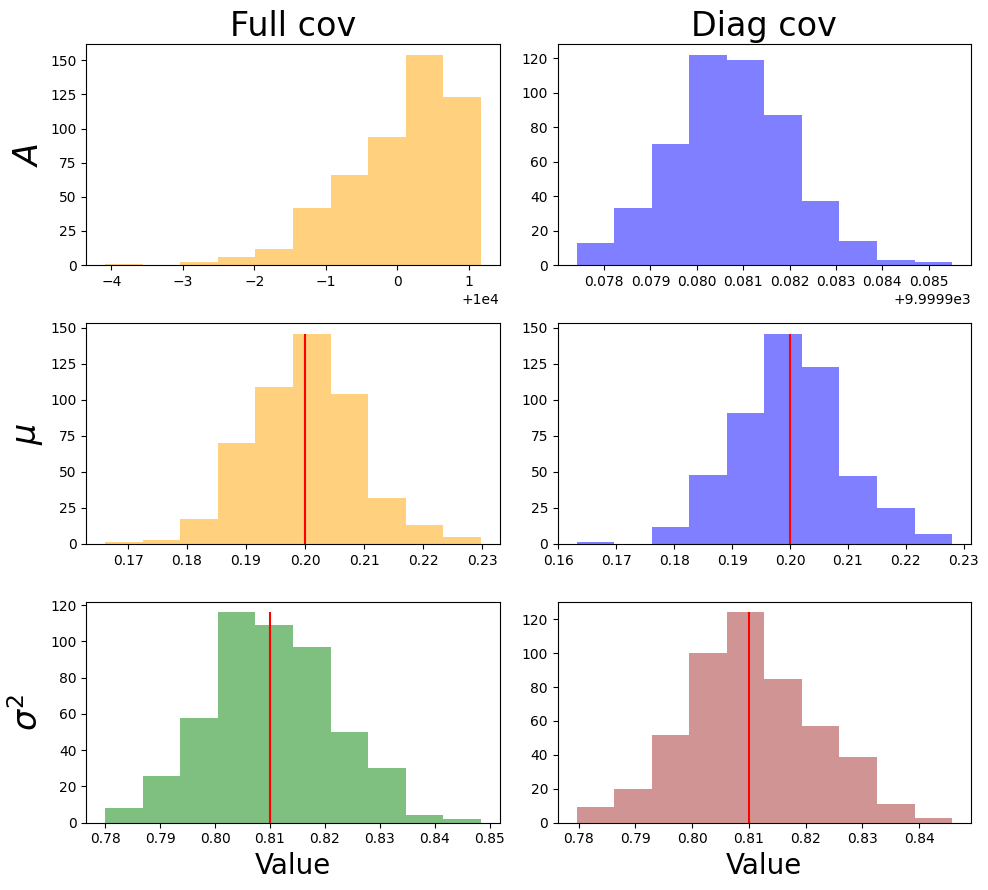

In [120]:
fig, ax = plt.subplots(3, 2, figsize=(10, 9))

# Plot for A with full covariance
h, _, _ = ax[0, 0].hist(fitted_params[:, 0], label="A full cov", color='orange', alpha=0.5)
#ax[0, 0].vlines(1200, 0, h.max(), color='r')  # Assuming 1200 as the correct value for A
ax[0, 0].set_title("Full cov", fontsize=24)
ax[0, 0].set_ylabel("$A$", fontsize=24)

# Plot for A with diagonal covariance
h, _, _ = ax[0, 1].hist(fitted_params_diag[:, 0], label="A diag cov", color='b', alpha=0.5)
#ax[0, 1].vlines(1200, 0, h.max(), color='r')
ax[0, 1].set_title("Diag cov", fontsize=24)

# Plot for mu with full covariance
h, _, _ = ax[1, 0].hist(fitted_params[:, 1], label="mu full cov", color='orange', alpha=0.5)
ax[1, 0].vlines(mu_true, 0, h.max(), color='r')
ax[1, 0].set_ylabel("$\\mu$", fontsize=24)

# Plot for mu with diagonal covariance
h, _, _ = ax[1, 1].hist(fitted_params_diag[:, 1], label="mu diag cov", color='b', alpha=0.5)
ax[1, 1].vlines(mu_true, 0, h.max(), color='r')

# Plot for variance with full covariance
h, _, _ = ax[2, 0].hist(fitted_params[:, 2], label="var full cov", color='g', alpha=0.5)
ax[2, 0].vlines(var_true, 0, h.max(), color='r')
ax[2, 0].set_ylabel("$\\sigma^2$", fontsize=24)

# Plot for variance with diagonal covariance
h, _, _ = ax[2, 1].hist(fitted_params_diag[:, 2], label="var diag cov", color='brown', alpha=0.5)
ax[2, 1].vlines(var_true, 0, h.max(), color='r', label='Truth')

# Add labels to the x-axis for the bottom plots
ax[2, 0].set_xlabel("Value", fontsize=20)
ax[2, 1].set_xlabel("Value", fontsize=20)

plt.tight_layout()
plt.savefig('figures/good.pdf', bbox_inches='tight')
plt.show()

In [94]:
# Create a table for the full covariance results
table_full = PrettyTable()
table_full.title = 'Full Covariance Results'
table_full.field_names = ["Parameter", "Mean", "1 Sigma", "Asymptotic Interval"]

table_full.add_row([
    "Mu",
    f"{np.mean(fitted_params[:, 0]):.4f}",
    f"{np.std(fitted_params[:, 0]):.4f}",
    f"{0.5*np.diff(np.mean(intervals, axis=0)[0])[0]:.4f}"
])
table_full.add_row([
    "Var",
    f"{np.mean(fitted_params[:, 1]):.4f}",
    f"{np.std(fitted_params[:, 1]):.4f}",
    f"{0.5*np.diff(np.mean(intervals, axis=0)[1])[0]:.4f}"
])

# Create a table for the diagonal covariance results
table_diag = PrettyTable()
table_diag.title = 'Diagonal Covariance Results'
table_diag.field_names = ["Parameter", "Mean", "1 Sigma CI", "Asymptotic Interval"]

table_diag.add_row([
    "Mu",
    f"{np.mean(fitted_params_diag[:, 0]):.4f}",
    f"{np.std(fitted_params_diag[:, 0]):.4f}",
    f"{0.5*np.diff(np.mean(intervals_diag, axis=0)[0])[0]:.4f}"
])
table_diag.add_row([
    "Var",
    f"{np.mean(fitted_params_diag[:, 1]):.4f}",
    f"{np.std(fitted_params_diag[:, 1]):.4f}",
    f"{0.5*np.diff(np.mean(intervals_diag, axis=0)[1])[0]:.4f}"
])

# Print the tables
print(table_full)
print(table_diag)

+--------------------------------------------------------+
|                Full Covariance Results                 |
+-----------+------------+---------+---------------------+
| Parameter |    Mean    | 1 Sigma | Asymptotic Interval |
+-----------+------------+---------+---------------------+
|     Mu    | 10003.4190 |  0.7788 |         nan         |
|    Var    |   0.1974   |  0.0089 |         nan         |
+-----------+------------+---------+---------------------+
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                                                     Diagonal Covariance Results                      

/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/numpy/core/_methods.py:118: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
